In [1]:
# read_csv参数的详细介绍 参考地址 https://www.cnblogs.com/datablog/p/6127000.html

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell


In [3]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
InteractiveShell.ast_node_interactivity = "all"

In [24]:
# 下载数据集
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/JQC/.keras/datasets/auto-mpg.data'

In [25]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
# 
raw_dataset = pd.read_csv(dataset_path, 
                          names=column_names, 
                          comment='\t', 
                          sep=' ',
#                           na_values = "?",  # 如果有缺失值,使用这个符号代替
                          skipinitialspace=True, # 跳过空行
                         )
raw_dataset.shape
raw_dataset.head()
raw_dataset.info()

(398, 8)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
MPG             398 non-null float64
Cylinders       398 non-null int64
Displacement    398 non-null float64
Horsepower      398 non-null object
Weight          398 non-null float64
Acceleration    398 non-null float64
Model Year      398 non-null int64
Origin          398 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [26]:
# data = raw_dataset.copy()
# 去重
raw_dataset.drop_duplicates(inplace=True)
# 去除na值
raw_dataset.dropna(inplace=True)
raw_dataset = raw_dataset.loc[raw_dataset['Horsepower'] != '?']
raw_dataset['Horsepower'] = pd.to_numeric(raw_dataset['Horsepower'])

In [27]:
# # 将标签转化为独热编码
label = raw_dataset.pop('Origin')
raw_dataset['USA'] = (label== 1) * 1.0
raw_dataset['Europe'] = (label == 2) * 1.0
raw_dataset['Japan'] = (label == 3) * 1.0
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


In [28]:
train_data = raw_dataset.sample(frac=0.8, random_state=0)
test_data = raw_dataset.drop(train_data.index)

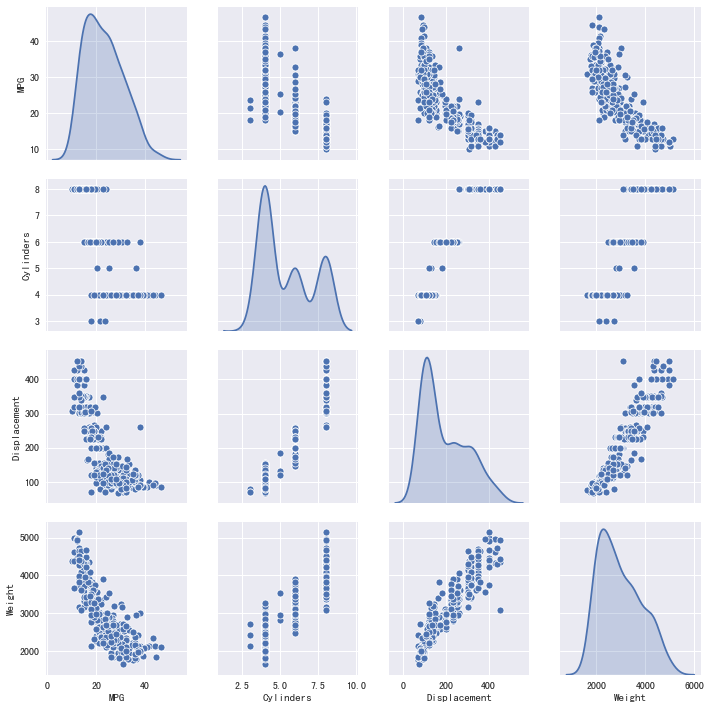

In [29]:
# 查看下面任意两个特征之间的分布
sns.pairplot(train_data[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [33]:
train_stats = train_data.describe()
train_stats.pop('MPG')
train_stats = train_stats.T
train_stats

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [34]:
type(train_stats)

pandas.core.frame.DataFrame

In [35]:
# 取出标签
train_labels = train_data.pop('MPG')
test_labels = test_data.pop('MPG')



In [36]:
train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0


In [37]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

norm_train_data = norm(train_data)
norm_test_data = norm(test_data)

In [38]:
train_data.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [57]:
# 建立模型
# model = keras.Sequential([
#     keras.layers.Dense(64, activation='relu', input_shape=[len(train_data.columns)]),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(1)
# ])

# model.compile(optimizer=keras.optimizers.RMSprop(0.001), 
#               loss='mse', 
#               metrics=['mae', 'mse'],
#              )

def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [40]:
norm_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


In [43]:
# 测试一下模型
example_batch = norm_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.03041622],
       [-0.03419304],
       [-0.2644686 ],
       [-0.07471433],
       [-0.06391266],
       [-0.07984515],
       [-0.05601073],
       [ 0.18833202],
       [-0.2368497 ],
       [-0.05710424]], dtype=float32)

In [46]:
# 开始训练数据
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
EPOCHS = 1000
history = model.fit(norm_train_data, 
          train_labels, 
          epochs=EPOCHS, 
          validation_split=0.2, 
          verbose=0, 
          callbacks=[PrintDot()], # 参考链接 https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/callbacks
     )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [51]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
990,0.971426,0.551137,0.971426,17.382051,2.966740,17.382051,990
991,0.952933,0.548580,0.952933,17.509954,3.002766,17.509956,991
992,1.026572,0.580558,1.026572,17.273229,2.981768,17.273228,992
993,0.810867,0.481833,0.810867,17.603048,3.011991,17.603046,993
994,1.021344,0.603536,1.021344,17.364803,2.951276,17.364803,994
995,0.830352,0.480133,0.830352,17.470206,2.993857,17.470207,995
996,1.011934,0.621759,1.011934,17.445327,2.977143,17.445328,996
997,0.837173,0.520259,0.837173,17.146027,2.959574,17.146027,997
998,1.142177,0.601765,1.142177,17.353642,3.042845,17.353643,998
999,0.921404,0.546792,0.921404,17.384847,3.026117,17.384848,999


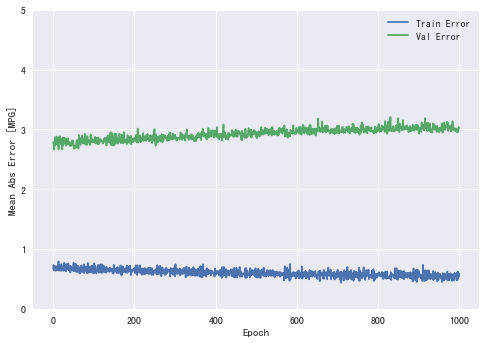

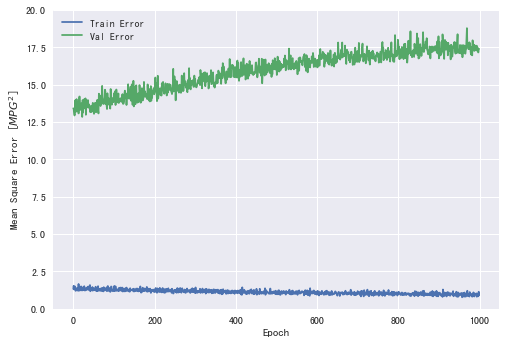

In [54]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 1ms/sample - loss: 573.9533 - mae: 22.7019 - mse: 573.9533 - val_loss: 567.6062 - val_mae: 22.5553 - val_mse: 567.6061
Epoch 2/1000
251/251 [==============================] - 0s 65us/sample - loss: 527.6555 - mae: 21.7119 - mse: 527.6555 - val_loss: 518.2559 - val_mae: 21.4629 - val_mse: 518.2559
Epoch 3/1000
251/251 [==============================] - 0s 79us/sample - loss: 480.2322 - mae: 20.6218 - mse: 480.2322 - val_loss: 465.7552 - val_mae: 20.2113 - val_mse: 465.7552
Epoch 4/1000
251/251 [==============================] - 0s 90us/sample - loss: 429.8004 - mae: 19.3782 - mse: 429.8004 - val_loss: 409.4423 - val_mae: 18.7835 - val_mse: 409.4423
Epoch 5/1000
251/251 [==============================] - 0s 77us/sample - loss: 375.7012 - mae: 17.9826 - mse: 375.7013 - val_loss: 349.1990 - val_mae: 17.1311 - val_mse: 349.1990
Epoch 6/1000
251/251 [==============================] - 0s 84

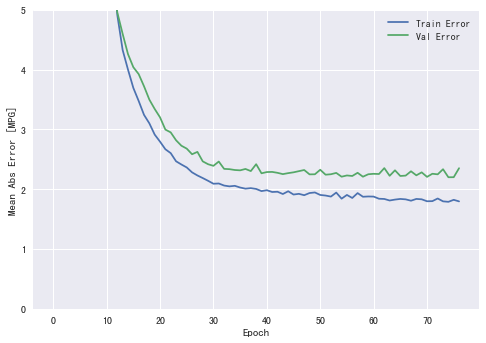

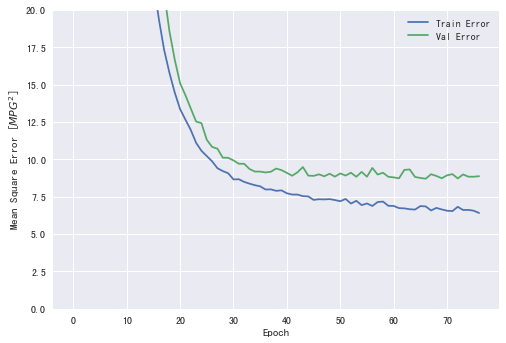

In [58]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(norm_train_data, 
                    train_labels, 
                    epochs=1000,
                    validation_split=0.2, 
                    verbose=1,
                    callbacks=[early_stop, PrintDot()]
                   )
plot_history(history)


In [59]:
loss, mae, mse = model.evaluate(norm_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


Testing set Mean Abs Error:  1.78 MPG


Text(0.5, 0, 'True Values [MPG]')

Text(0, 0.5, 'Predictions [MPG]')

(7.226375448028675, 46.07362455197133, 8.894565787992555, 40.478897842683715)

(7.226375448028675, 46.07362455197133, 8.894565787992555, 47.741814891935206)

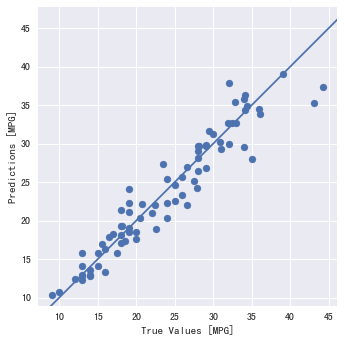

In [67]:
test_predictions = model.predict(norm_test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 100], [-100, 100])

(array([ 1.,  2.,  0.,  0.,  0.,  1.,  1.,  3.,  0.,  5.,  3.,  6.,  6.,
        10.,  8.,  8., 11.,  3.,  3.,  2.,  2.,  1.,  0.,  1.,  1.]),
 array([-7.85001907, -7.30241296, -6.75480685, -6.20720074, -5.65959464,
        -5.11198853, -4.56438242, -4.01677631, -3.4691702 , -2.92156409,
        -2.37395798, -1.82635187, -1.27874576, -0.73113965, -0.18353354,
         0.36407257,  0.91167868,  1.45928479,  2.0068909 ,  2.55449701,
         3.10210312,  3.64970923,  4.19731534,  4.74492145,  5.29252756,
         5.84013367]),
 <a list of 25 Patch objects>)

Text(0.5, 0, 'Prediction Error [MPG]')

Text(0, 0.5, 'Count')

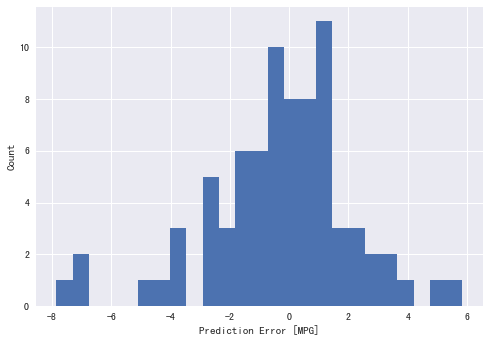

In [70]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")